# Pratical excersice 1: Chest and breast classification

Before you start to solve the exercise, please write your TUM-IDs alongside the names of all group members. This will enable us to assign grades accurately. Thank you.

Member 1: Doan Xuan Viet, Pham; 03698056

Member 2: Schulz, Julien; 03723706

Member 3: Jehkul, Janik; 03781262


In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=388f55ff6fbd627a95e81089e89fbe5e1769ceeb1158168b1cf6f7ce36073234
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from matplotlib import pyplot as plt

import medmnist
from medmnist import INFO

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

CUDA is available. Training on GPU.


## Task 1: 2D breast ultrasound classification.

## Dataloading
We first load a 2D dataset breast ultrasound dataset-BreastMNIST, preprocess it and encapsulate it into dataloader form. Please fill the empty blanks in the following bloacks. You are expected to show the details of training, validation, and test dataset.

In [3]:
data_flag_2d = 'breastmnist' # here the name of dataset should be passed.
download = True

info = INFO[data_flag_2d] # INFO is embedded in the medmnist containing basic information of datasets
print(info)
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

{'python_class': 'BreastMNIST', 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/breastmnist.npz?download=1', 'MD5': '750601b1f35ba3300ea97c75c52ff8f6', 'task': 'binary-class', 'label': {'0': 'malignant', '1': 'normal, benign'}, 'n_channels': 1, 'n_samples': {'train': 546, 'val': 78, 'test': 156}, 'license': 'CC BY 4.0'}


In [4]:
"""
Here goes with the hyperparameters for your model.
"""
# hyparameters
BATCH_SIZE = 128
EPOCH_NUM = 100
lr = 0.001

In [5]:
"""
Please generate datasets and dataloaders for training, validation, and test dataset.
Datasets should be an object of DataClass and dataloaders should be an object of torch.utils.data.DataLoader.
"""

# preprocessing such as conversion to tensor and normalization
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# get the data class
train_dataset = DataClass(split="train", transform=data_transforms, download=download)
test_dataset = DataClass(split="test", transform=data_transforms, download=download)
val_dataset = DataClass(split="val", transform=data_transforms, download=download)

# encapsulate datasets into Dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 559580/559580 [00:00<00:00, 673954.52it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 78
    Root location: /root/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 

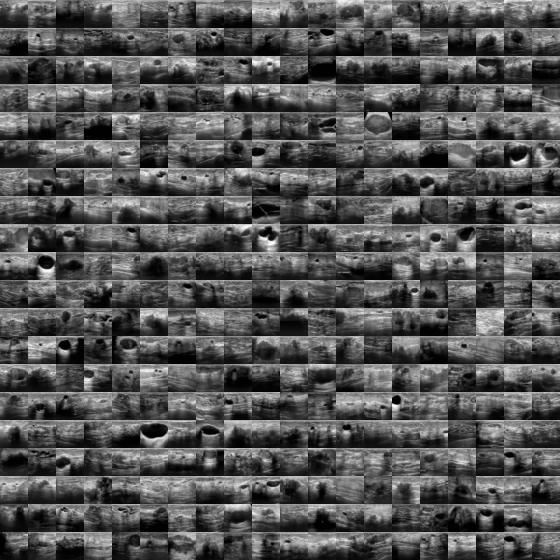

In [6]:
"""
This block shows the details of the datasets you generated above.
"""
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)
train_dataset.montage(length=20)

Please fill the blanks in the following block to show the image and its corresponding class label of 2 subjects:
1. the 50th subject in training dataset
2. the 20th subject in test dataset



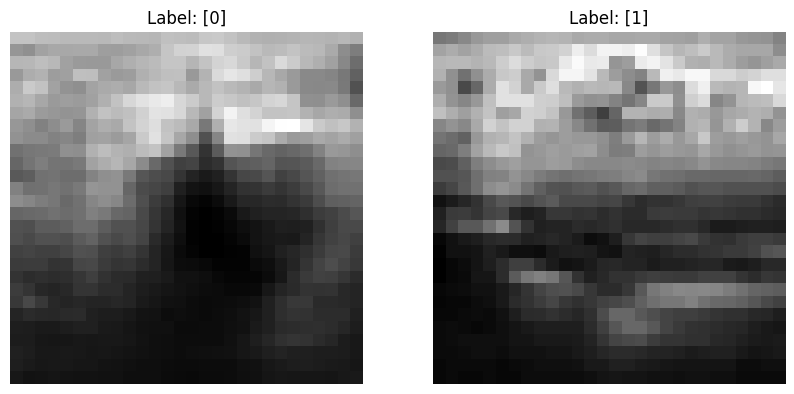

In [7]:
"""
Please query images and labels and visualize both images with labels as title.
"""
# query images and corresponding labels

im_1, label_1 = train_dataset[49]
im_2, label_2 = test_dataset[19]

# visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(im_1[0], cmap='gray')
ax2.imshow(im_2[0], cmap='gray')

ax1.set_title(f"Label: {label_1}")
ax1.axis('off')
ax2.set_title(f"Label: {label_2}")
ax2.axis('off')

plt.show()


## Upsampling and downsampling
Upsample the aforementioned subjects with bilinear algorithm from 28$\times$28 to 56$\times$56 and apply a 2D max pooling over the same subjects with kernel size equals 2 and stride equals 2.

**You are expected to use classes implememted in torch.nn.**
*Hit: Pay attention to the dimension of inputs.*


The size of resulted images: torch.Size([1, 28, 28]).


<Figure size 640x480 with 0 Axes>

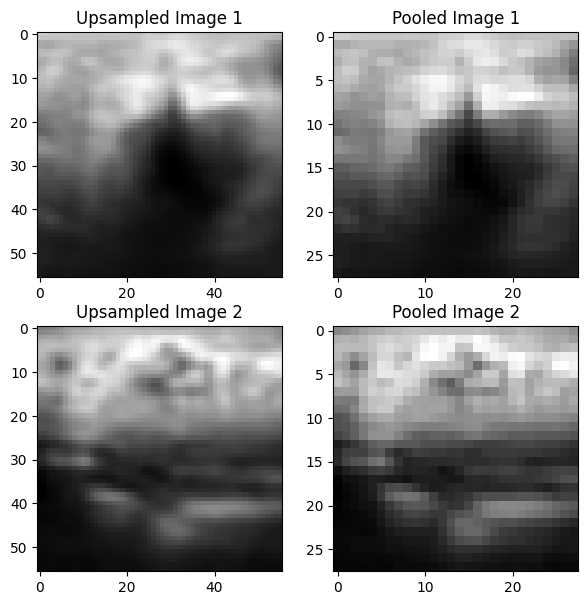

In [8]:
"""
Please realize upsampling and pooling of target images.
Visualize them with 2*2 subplots and print the size of images.

"""

# upsampling
upsample = nn.Upsample(size=(56,56), mode="bilinear")
upsampled_im_1 = upsample(im_1.unsqueeze(0))
upsampled_im_2 = upsample(im_2.unsqueeze(0))

# downsampling
pooled_im_1 = nn.MaxPool2d(2, 2)(upsampled_im_1)
pooled_im_2 = nn.MaxPool2d(2, 2)(upsampled_im_2)

# visualization
plt.figure()
f, axarr = plt.subplots(2, 2, figsize=(7, 7))
axarr[0, 0].imshow(upsampled_im_1[0][0], cmap='gray')
axarr[0, 1].imshow(pooled_im_1[0][0], cmap='gray')
axarr[1, 0].imshow(upsampled_im_2[0][0], cmap='gray')
axarr[1, 1].imshow(pooled_im_2[0][0], cmap='gray')

axarr[0, 0].set_title("Upsampled Image 1")
axarr[0, 1].set_title("Pooled Image 1")
axarr[1, 0].set_title("Upsampled Image 2")
axarr[1, 1].set_title("Pooled Image 2")

print(f'The size of resulted images: {im_1.shape}.')

## Model implementation

Here you should implement a basic CNN model with 5 convolutional layers. The output layer should be two linear layers. The output activation is sigmoid function.

Define a loss criterion that measures the Binary Cross Entropy between the target and the input probabilities with mean reduction.

In [9]:
"""
Please design a CNN model. You are execpted to invole batch normalization and pooling.
"""

# define the architecture of the model
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        # 1 x 28 x 28
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # 16 x 14 x 14
        self.conv_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        # 32 x 7 x 7
        self.conv_3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # 64 x 6 x 6
        self.conv_4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # 128 x 5 x 5
        self.conv_5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        # 256 x 3 x 3
        self.fc_1 = nn.Linear(256 * 3 * 3, 256)
        # # 1 x 512
        self.fc_2 = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        # # 1 x num_classes

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = x.view(x.size(0), -1)
        x = self.fc_1(x)
        x = self.fc_2(x)
        return x

# initialize your model
cnn_model = CNN(in_channels=n_channels, num_classes=n_classes)
cnn_model.to(device)
# define the BCE loss function and an optimizer you prefer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

Here shows the summary of designed CNN architecture.

In [10]:
"""
Here shows the summary of the model you designed with input size of your data and batch size you chose.
Please pass the size of data size to SAMPLE_DATASIZE.
"""
from torchsummary import summary
SAMPLE_DATASIZE = (1, 28, 28)
summary(cnn_model, SAMPLE_DATASIZE, BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 28, 28]             160
       BatchNorm2d-2          [128, 16, 28, 28]              32
              ReLU-3          [128, 16, 28, 28]               0
         MaxPool2d-4          [128, 16, 14, 14]               0
            Conv2d-5          [128, 32, 14, 14]           4,640
       BatchNorm2d-6          [128, 32, 14, 14]              64
              ReLU-7          [128, 32, 14, 14]               0
         MaxPool2d-8            [128, 32, 7, 7]               0
            Conv2d-9            [128, 64, 6, 6]           8,256
      BatchNorm2d-10            [128, 64, 6, 6]             128
             ReLU-11            [128, 64, 6, 6]               0
           Conv2d-12           [128, 128, 5, 5]          32,896
      BatchNorm2d-13           [128, 128, 5, 5]             256
             ReLU-14           [128, 12

## Training and evaluation

Please fill the blanks in train and test functions.

In [11]:
"""
Please define functions for training and testing.
- train:
    input: dataloader, model
    output: loss_values for training and validation which is a list containing losses for all epochs.
            trained_model
- test:
    input: dataloader, model
    output: auc, acc
    Please also plot the test ROC curve for each class.
"""
# train and validation
def train(train_loader, model):
    loss_values = []
    val_loss_values = []

    for epoch in range(EPOCH_NUM):
        # Training
        model.train()
        epoch_loss = 0
        step = 0
        for inputs, labels in tqdm(train_loader):
            step += 1
            inputs, labels = inputs.to(torch.float32).to(device), labels.to(torch.float32).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= step
        print(f"Epoch training loss: {epoch_loss:.3f}")
        loss_values.append(epoch_loss)

        # Validate each epoch
        model.eval()
        val_epoch_loss = 0
        val_step = 0
        with torch.no_grad():
            for val_inputs, val_labels in tqdm(val_loader):
                val_step += 1
                val_inputs, val_labels = val_inputs.to(torch.float32).to(device), val_labels.to(torch.float32).to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_epoch_loss += val_loss.item()
            val_epoch_loss /= val_step
            print(f"Epoch validation loss: {val_epoch_loss:.3f}")
            val_loss_values.append(val_epoch_loss)

    return loss_values, val_loss_values, model

# test
def test(test_loader, model):
    test_loss_values = []

    model.eval()
    test_outputs_list = []
    test_labels_list = []
    test_loss = 0
    test_step = 0
    with torch.no_grad():
        for test_inputs, test_labels in tqdm(test_loader):
            test_step += 1
            test_inputs, test_labels = test_inputs.to(torch.float32).to(device), test_labels.to(torch.float32).to(device)
            test_outputs = model(test_inputs)
            test_loss += criterion(test_outputs, test_labels)
            test_outputs_list.extend(test_outputs.cpu().numpy())
            test_labels_list.extend(test_labels.cpu().numpy())

        test_loss /= test_step
        test_loss_values.append(test_loss)

    auc = roc_auc_score(test_labels_list, test_outputs_list)
    acc = accuracy_score(test_labels_list, [1 if p >= 0.5 else 0 for p in test_outputs_list])

    return auc, acc

100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Epoch training loss: 0.595


100%|██████████| 1/1 [00:00<00:00, 37.62it/s]


Epoch validation loss: 0.609


100%|██████████| 5/5 [00:00<00:00, 31.42it/s]


Epoch training loss: 0.589


100%|██████████| 1/1 [00:00<00:00, 47.18it/s]


Epoch validation loss: 0.607


100%|██████████| 5/5 [00:00<00:00, 33.25it/s]


Epoch training loss: 0.568


100%|██████████| 1/1 [00:00<00:00, 44.98it/s]


Epoch validation loss: 0.603


100%|██████████| 5/5 [00:00<00:00, 32.11it/s]


Epoch training loss: 0.574


100%|██████████| 1/1 [00:00<00:00, 49.43it/s]


Epoch validation loss: 0.599


100%|██████████| 5/5 [00:00<00:00, 29.94it/s]


Epoch training loss: 0.577


100%|██████████| 1/1 [00:00<00:00, 48.17it/s]


Epoch validation loss: 0.594


100%|██████████| 5/5 [00:00<00:00, 31.07it/s]


Epoch training loss: 0.579


100%|██████████| 1/1 [00:00<00:00, 48.19it/s]


Epoch validation loss: 0.589


100%|██████████| 5/5 [00:00<00:00, 32.27it/s]


Epoch training loss: 0.571


100%|██████████| 1/1 [00:00<00:00, 47.26it/s]


Epoch validation loss: 0.586


100%|██████████| 5/5 [00:00<00:00, 33.36it/s]


Epoch training loss: 0.560


100%|██████████| 1/1 [00:00<00:00, 42.92it/s]


Epoch validation loss: 0.583


100%|██████████| 5/5 [00:00<00:00, 32.26it/s]


Epoch training loss: 0.592


100%|██████████| 1/1 [00:00<00:00, 48.01it/s]


Epoch validation loss: 0.580


100%|██████████| 5/5 [00:00<00:00, 31.10it/s]


Epoch training loss: 0.573


100%|██████████| 1/1 [00:00<00:00, 46.08it/s]


Epoch validation loss: 0.578


100%|██████████| 5/5 [00:00<00:00, 32.50it/s]


Epoch training loss: 0.582


100%|██████████| 1/1 [00:00<00:00, 46.65it/s]


Epoch validation loss: 0.576


100%|██████████| 5/5 [00:00<00:00, 26.44it/s]


Epoch training loss: 0.563


100%|██████████| 1/1 [00:00<00:00, 32.15it/s]


Epoch validation loss: 0.575


100%|██████████| 5/5 [00:00<00:00, 24.83it/s]


Epoch training loss: 0.578


100%|██████████| 1/1 [00:00<00:00, 35.74it/s]


Epoch validation loss: 0.573


100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Epoch training loss: 0.570


100%|██████████| 1/1 [00:00<00:00, 41.57it/s]


Epoch validation loss: 0.571


100%|██████████| 5/5 [00:00<00:00, 33.49it/s]


Epoch training loss: 0.576


100%|██████████| 1/1 [00:00<00:00, 49.42it/s]


Epoch validation loss: 0.570


100%|██████████| 5/5 [00:00<00:00, 32.37it/s]


Epoch training loss: 0.564


100%|██████████| 1/1 [00:00<00:00, 48.69it/s]


Epoch validation loss: 0.568


100%|██████████| 5/5 [00:00<00:00, 33.92it/s]


Epoch training loss: 0.564


100%|██████████| 1/1 [00:00<00:00, 39.97it/s]


Epoch validation loss: 0.566


100%|██████████| 5/5 [00:00<00:00, 32.23it/s]


Epoch training loss: 0.552


100%|██████████| 1/1 [00:00<00:00, 50.84it/s]


Epoch validation loss: 0.565


100%|██████████| 5/5 [00:00<00:00, 32.15it/s]


Epoch training loss: 0.556


100%|██████████| 1/1 [00:00<00:00, 46.48it/s]


Epoch validation loss: 0.563


100%|██████████| 5/5 [00:00<00:00, 30.53it/s]


Epoch training loss: 0.559


100%|██████████| 1/1 [00:00<00:00, 48.06it/s]


Epoch validation loss: 0.561


100%|██████████| 5/5 [00:00<00:00, 33.03it/s]


Epoch training loss: 0.558


100%|██████████| 1/1 [00:00<00:00, 47.46it/s]


Epoch validation loss: 0.560


100%|██████████| 5/5 [00:00<00:00, 25.47it/s]


Epoch training loss: 0.566


100%|██████████| 1/1 [00:00<00:00, 30.53it/s]


Epoch validation loss: 0.558


100%|██████████| 5/5 [00:00<00:00, 24.04it/s]


Epoch training loss: 0.541


100%|██████████| 1/1 [00:00<00:00, 34.28it/s]


Epoch validation loss: 0.557


100%|██████████| 5/5 [00:00<00:00, 24.07it/s]


Epoch training loss: 0.547


100%|██████████| 1/1 [00:00<00:00, 35.79it/s]


Epoch validation loss: 0.555


100%|██████████| 5/5 [00:00<00:00, 25.02it/s]


Epoch training loss: 0.554


100%|██████████| 1/1 [00:00<00:00, 32.43it/s]


Epoch validation loss: 0.553


100%|██████████| 5/5 [00:00<00:00, 24.35it/s]


Epoch training loss: 0.549


100%|██████████| 1/1 [00:00<00:00, 30.13it/s]


Epoch validation loss: 0.552


100%|██████████| 5/5 [00:00<00:00, 24.76it/s]


Epoch training loss: 0.550


100%|██████████| 1/1 [00:00<00:00, 29.77it/s]


Epoch validation loss: 0.550


100%|██████████| 5/5 [00:00<00:00, 24.59it/s]


Epoch training loss: 0.555


100%|██████████| 1/1 [00:00<00:00, 39.69it/s]


Epoch validation loss: 0.549


100%|██████████| 5/5 [00:00<00:00, 25.57it/s]


Epoch training loss: 0.534


100%|██████████| 1/1 [00:00<00:00, 34.69it/s]


Epoch validation loss: 0.547


100%|██████████| 5/5 [00:00<00:00, 22.96it/s]


Epoch training loss: 0.541


100%|██████████| 1/1 [00:00<00:00, 39.46it/s]


Epoch validation loss: 0.546


100%|██████████| 5/5 [00:00<00:00, 21.74it/s]


Epoch training loss: 0.530


100%|██████████| 1/1 [00:00<00:00, 29.50it/s]


Epoch validation loss: 0.545


100%|██████████| 5/5 [00:00<00:00, 26.37it/s]


Epoch training loss: 0.532


100%|██████████| 1/1 [00:00<00:00, 43.05it/s]


Epoch validation loss: 0.544


100%|██████████| 5/5 [00:00<00:00, 29.29it/s]


Epoch training loss: 0.531


100%|██████████| 1/1 [00:00<00:00, 42.37it/s]


Epoch validation loss: 0.543


100%|██████████| 5/5 [00:00<00:00, 33.32it/s]


Epoch training loss: 0.547


100%|██████████| 1/1 [00:00<00:00, 40.90it/s]


Epoch validation loss: 0.541


100%|██████████| 5/5 [00:00<00:00, 33.78it/s]


Epoch training loss: 0.531


100%|██████████| 1/1 [00:00<00:00, 51.04it/s]


Epoch validation loss: 0.540


100%|██████████| 5/5 [00:00<00:00, 32.55it/s]


Epoch training loss: 0.528


100%|██████████| 1/1 [00:00<00:00, 46.98it/s]


Epoch validation loss: 0.539


100%|██████████| 5/5 [00:00<00:00, 30.76it/s]


Epoch training loss: 0.528


100%|██████████| 1/1 [00:00<00:00, 25.24it/s]


Epoch validation loss: 0.537


100%|██████████| 5/5 [00:00<00:00, 34.30it/s]


Epoch training loss: 0.534


100%|██████████| 1/1 [00:00<00:00, 52.28it/s]


Epoch validation loss: 0.536


100%|██████████| 5/5 [00:00<00:00, 32.80it/s]


Epoch training loss: 0.526


100%|██████████| 1/1 [00:00<00:00, 54.45it/s]


Epoch validation loss: 0.535


100%|██████████| 5/5 [00:00<00:00, 34.18it/s]


Epoch training loss: 0.530


100%|██████████| 1/1 [00:00<00:00, 38.53it/s]


Epoch validation loss: 0.534


100%|██████████| 5/5 [00:00<00:00, 33.11it/s]


Epoch training loss: 0.541


100%|██████████| 1/1 [00:00<00:00, 45.52it/s]


Epoch validation loss: 0.533


100%|██████████| 5/5 [00:00<00:00, 34.21it/s]


Epoch training loss: 0.527


100%|██████████| 1/1 [00:00<00:00, 45.68it/s]


Epoch validation loss: 0.532


100%|██████████| 5/5 [00:00<00:00, 32.12it/s]


Epoch training loss: 0.522


100%|██████████| 1/1 [00:00<00:00, 54.49it/s]


Epoch validation loss: 0.531


100%|██████████| 5/5 [00:00<00:00, 32.10it/s]


Epoch training loss: 0.533


100%|██████████| 1/1 [00:00<00:00, 40.97it/s]


Epoch validation loss: 0.530


100%|██████████| 5/5 [00:00<00:00, 35.48it/s]


Epoch training loss: 0.526


100%|██████████| 1/1 [00:00<00:00, 48.54it/s]


Epoch validation loss: 0.529


100%|██████████| 5/5 [00:00<00:00, 32.71it/s]


Epoch training loss: 0.511


100%|██████████| 1/1 [00:00<00:00, 47.08it/s]


Epoch validation loss: 0.528


100%|██████████| 5/5 [00:00<00:00, 33.69it/s]


Epoch training loss: 0.526


100%|██████████| 1/1 [00:00<00:00, 49.07it/s]


Epoch validation loss: 0.527


100%|██████████| 5/5 [00:00<00:00, 30.75it/s]


Epoch training loss: 0.520


100%|██████████| 1/1 [00:00<00:00, 45.00it/s]


Epoch validation loss: 0.526


100%|██████████| 5/5 [00:00<00:00, 33.50it/s]


Epoch training loss: 0.514


100%|██████████| 1/1 [00:00<00:00, 44.64it/s]


Epoch validation loss: 0.526


100%|██████████| 5/5 [00:00<00:00, 33.42it/s]


Epoch training loss: 0.511


100%|██████████| 1/1 [00:00<00:00, 36.57it/s]


Epoch validation loss: 0.525


100%|██████████| 5/5 [00:00<00:00, 34.59it/s]


Epoch training loss: 0.513


100%|██████████| 1/1 [00:00<00:00, 43.44it/s]


Epoch validation loss: 0.525


100%|██████████| 5/5 [00:00<00:00, 33.39it/s]


Epoch training loss: 0.511


100%|██████████| 1/1 [00:00<00:00, 46.92it/s]


Epoch validation loss: 0.524


100%|██████████| 5/5 [00:00<00:00, 32.20it/s]


Epoch training loss: 0.508


100%|██████████| 1/1 [00:00<00:00, 33.23it/s]


Epoch validation loss: 0.523


100%|██████████| 5/5 [00:00<00:00, 32.73it/s]


Epoch training loss: 0.516


100%|██████████| 1/1 [00:00<00:00, 48.29it/s]


Epoch validation loss: 0.522


100%|██████████| 5/5 [00:00<00:00, 31.22it/s]


Epoch training loss: 0.504


100%|██████████| 1/1 [00:00<00:00, 58.18it/s]


Epoch validation loss: 0.521


100%|██████████| 5/5 [00:00<00:00, 32.88it/s]


Epoch training loss: 0.507


100%|██████████| 1/1 [00:00<00:00, 39.80it/s]


Epoch validation loss: 0.521


100%|██████████| 5/5 [00:00<00:00, 33.19it/s]


Epoch training loss: 0.507


100%|██████████| 1/1 [00:00<00:00, 44.61it/s]


Epoch validation loss: 0.520


100%|██████████| 5/5 [00:00<00:00, 32.87it/s]


Epoch training loss: 0.502


100%|██████████| 1/1 [00:00<00:00, 40.07it/s]


Epoch validation loss: 0.520


100%|██████████| 5/5 [00:00<00:00, 29.39it/s]


Epoch training loss: 0.509


100%|██████████| 1/1 [00:00<00:00, 52.21it/s]


Epoch validation loss: 0.519


100%|██████████| 5/5 [00:00<00:00, 32.28it/s]


Epoch training loss: 0.510


100%|██████████| 1/1 [00:00<00:00, 51.56it/s]


Epoch validation loss: 0.519


100%|██████████| 5/5 [00:00<00:00, 34.38it/s]


Epoch training loss: 0.504


100%|██████████| 1/1 [00:00<00:00, 38.39it/s]


Epoch validation loss: 0.518


100%|██████████| 5/5 [00:00<00:00, 33.17it/s]


Epoch training loss: 0.504


100%|██████████| 1/1 [00:00<00:00, 52.03it/s]


Epoch validation loss: 0.517


100%|██████████| 5/5 [00:00<00:00, 33.08it/s]


Epoch training loss: 0.507


100%|██████████| 1/1 [00:00<00:00, 42.57it/s]


Epoch validation loss: 0.517


100%|██████████| 5/5 [00:00<00:00, 31.32it/s]


Epoch training loss: 0.513


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


Epoch validation loss: 0.516


100%|██████████| 5/5 [00:00<00:00, 33.24it/s]


Epoch training loss: 0.497


100%|██████████| 1/1 [00:00<00:00, 48.87it/s]


Epoch validation loss: 0.516


100%|██████████| 5/5 [00:00<00:00, 34.24it/s]


Epoch training loss: 0.505


100%|██████████| 1/1 [00:00<00:00, 40.40it/s]


Epoch validation loss: 0.516


100%|██████████| 5/5 [00:00<00:00, 33.00it/s]


Epoch training loss: 0.507


100%|██████████| 1/1 [00:00<00:00, 47.26it/s]


Epoch validation loss: 0.515


100%|██████████| 5/5 [00:00<00:00, 33.62it/s]


Epoch training loss: 0.496


100%|██████████| 1/1 [00:00<00:00, 46.72it/s]


Epoch validation loss: 0.514


100%|██████████| 5/5 [00:00<00:00, 30.88it/s]


Epoch training loss: 0.502


100%|██████████| 1/1 [00:00<00:00, 47.55it/s]


Epoch validation loss: 0.513


100%|██████████| 5/5 [00:00<00:00, 34.00it/s]


Epoch training loss: 0.503


100%|██████████| 1/1 [00:00<00:00, 56.10it/s]


Epoch validation loss: 0.513


100%|██████████| 5/5 [00:00<00:00, 32.48it/s]


Epoch training loss: 0.500


100%|██████████| 1/1 [00:00<00:00, 43.38it/s]


Epoch validation loss: 0.513


100%|██████████| 5/5 [00:00<00:00, 31.77it/s]


Epoch training loss: 0.508


100%|██████████| 1/1 [00:00<00:00, 46.11it/s]


Epoch validation loss: 0.513


100%|██████████| 5/5 [00:00<00:00, 32.65it/s]


Epoch training loss: 0.507


100%|██████████| 1/1 [00:00<00:00, 39.11it/s]


Epoch validation loss: 0.512


100%|██████████| 5/5 [00:00<00:00, 31.42it/s]


Epoch training loss: 0.500


100%|██████████| 1/1 [00:00<00:00, 40.55it/s]


Epoch validation loss: 0.512


100%|██████████| 5/5 [00:00<00:00, 32.02it/s]


Epoch training loss: 0.486


100%|██████████| 1/1 [00:00<00:00, 47.90it/s]


Epoch validation loss: 0.511


100%|██████████| 5/5 [00:00<00:00, 32.62it/s]


Epoch training loss: 0.507


100%|██████████| 1/1 [00:00<00:00, 43.85it/s]


Epoch validation loss: 0.511


100%|██████████| 5/5 [00:00<00:00, 32.13it/s]


Epoch training loss: 0.486


100%|██████████| 1/1 [00:00<00:00, 40.29it/s]


Epoch validation loss: 0.511


100%|██████████| 5/5 [00:00<00:00, 32.50it/s]


Epoch training loss: 0.495


100%|██████████| 1/1 [00:00<00:00, 47.16it/s]


Epoch validation loss: 0.510


100%|██████████| 5/5 [00:00<00:00, 32.01it/s]


Epoch training loss: 0.492


100%|██████████| 1/1 [00:00<00:00, 31.77it/s]


Epoch validation loss: 0.509


100%|██████████| 5/5 [00:00<00:00, 33.54it/s]


Epoch training loss: 0.497


100%|██████████| 1/1 [00:00<00:00, 37.45it/s]


Epoch validation loss: 0.509


100%|██████████| 5/5 [00:00<00:00, 33.27it/s]


Epoch training loss: 0.518


100%|██████████| 1/1 [00:00<00:00, 41.62it/s]


Epoch validation loss: 0.508


100%|██████████| 5/5 [00:00<00:00, 30.81it/s]


Epoch training loss: 0.507


100%|██████████| 1/1 [00:00<00:00, 44.69it/s]


Epoch validation loss: 0.508


100%|██████████| 5/5 [00:00<00:00, 27.56it/s]


Epoch training loss: 0.502


100%|██████████| 1/1 [00:00<00:00, 27.70it/s]


Epoch validation loss: 0.508


100%|██████████| 5/5 [00:00<00:00, 22.32it/s]


Epoch training loss: 0.489


100%|██████████| 1/1 [00:00<00:00, 36.50it/s]


Epoch validation loss: 0.508


100%|██████████| 5/5 [00:00<00:00, 23.49it/s]


Epoch training loss: 0.487


100%|██████████| 1/1 [00:00<00:00, 31.94it/s]


Epoch validation loss: 0.508


100%|██████████| 5/5 [00:00<00:00, 24.55it/s]


Epoch training loss: 0.488


100%|██████████| 1/1 [00:00<00:00, 29.01it/s]


Epoch validation loss: 0.508


100%|██████████| 5/5 [00:00<00:00, 25.03it/s]


Epoch training loss: 0.490


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


Epoch validation loss: 0.507


100%|██████████| 5/5 [00:00<00:00, 23.44it/s]


Epoch training loss: 0.496


100%|██████████| 1/1 [00:00<00:00, 35.38it/s]


Epoch validation loss: 0.507


100%|██████████| 5/5 [00:00<00:00, 25.03it/s]


Epoch training loss: 0.488


100%|██████████| 1/1 [00:00<00:00, 36.39it/s]


Epoch validation loss: 0.506


100%|██████████| 5/5 [00:00<00:00, 22.49it/s]


Epoch training loss: 0.493


100%|██████████| 1/1 [00:00<00:00, 34.85it/s]


Epoch validation loss: 0.505


100%|██████████| 5/5 [00:00<00:00, 25.28it/s]


Epoch training loss: 0.484


100%|██████████| 1/1 [00:00<00:00, 33.02it/s]


Epoch validation loss: 0.505


100%|██████████| 5/5 [00:00<00:00, 22.16it/s]


Epoch training loss: 0.488


100%|██████████| 1/1 [00:00<00:00, 29.58it/s]


Epoch validation loss: 0.505


100%|██████████| 5/5 [00:00<00:00, 23.21it/s]


Epoch training loss: 0.491


100%|██████████| 1/1 [00:00<00:00, 31.22it/s]


Epoch validation loss: 0.505


100%|██████████| 5/5 [00:00<00:00, 28.96it/s]


Epoch training loss: 0.478


100%|██████████| 1/1 [00:00<00:00, 46.20it/s]


Epoch validation loss: 0.505


100%|██████████| 5/5 [00:00<00:00, 31.96it/s]


Epoch training loss: 0.484


100%|██████████| 1/1 [00:00<00:00, 45.09it/s]


Epoch validation loss: 0.504


100%|██████████| 5/5 [00:00<00:00, 32.06it/s]


Epoch training loss: 0.483


100%|██████████| 1/1 [00:00<00:00, 53.77it/s]


Epoch validation loss: 0.503


100%|██████████| 5/5 [00:00<00:00, 29.36it/s]


Epoch training loss: 0.471


100%|██████████| 1/1 [00:00<00:00, 32.27it/s]


Epoch validation loss: 0.503


100%|██████████| 5/5 [00:00<00:00, 32.41it/s]


Epoch training loss: 0.475


100%|██████████| 1/1 [00:00<00:00, 39.97it/s]


Epoch validation loss: 0.503


100%|██████████| 5/5 [00:00<00:00, 31.32it/s]


Epoch training loss: 0.482


100%|██████████| 1/1 [00:00<00:00, 40.32it/s]


Epoch validation loss: 0.503


100%|██████████| 5/5 [00:00<00:00, 30.28it/s]


Epoch training loss: 0.478


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


Epoch validation loss: 0.503


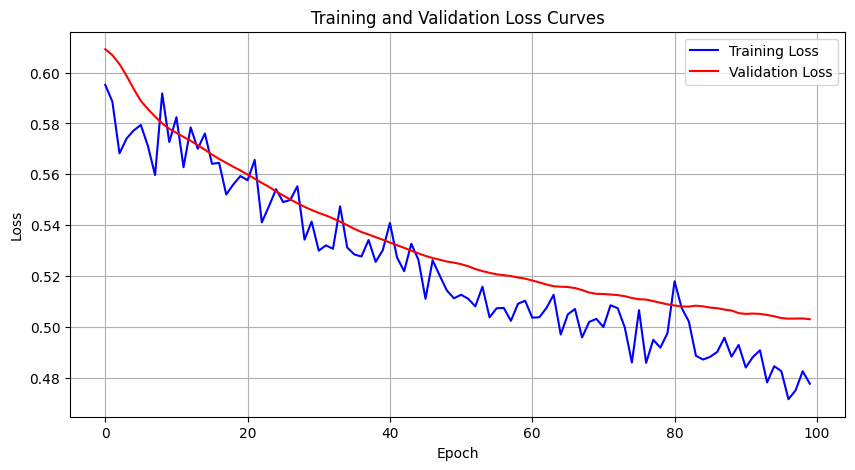

100%|██████████| 1/1 [00:00<00:00, 18.03it/s]

auc: 0.842, acc: 0.853


In [12]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
# train
loss_values, val_loss_values, model = train(train_loader=train_loader, model=cnn_model)

# show training and validation curves
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# test
auc, acc = test(test_loader=test_loader, model=cnn_model)
print(f'auc: {auc:.3f}, acc: {acc:.3f}') # round both to the first 3 digits

# 3D dataset NoduleMNIST3D

Please fill the blanks in the following block to create dataloaders for training, validation, and test on 3D dataset. The visualization of each dataset is expected.

{'python_class': 'NoduleMNIST3D', 'description': 'The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.', 'url': 'https://zenodo.org/record/6496656/files/nodulemnist3d.npz?download=1', 'MD5': '8755a7e9e05a4d9ce80a24c3e7a256f3', 'task': 'binary-class', 'label': {'0': 'benign', '1': 'malignant'}, 'n_channels': 1, 'n_samples': {'train': 1158, 'val': 165, 'test': 310}, 'license': 'CC BY 4.0'}


100%|██████████| 29299364/29299364 [00:03<00:00, 9233527.51it/s] 


Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Dataset NoduleMNIST3D (nodulemnist3d)
    Number of datapoints: 1158
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing 

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


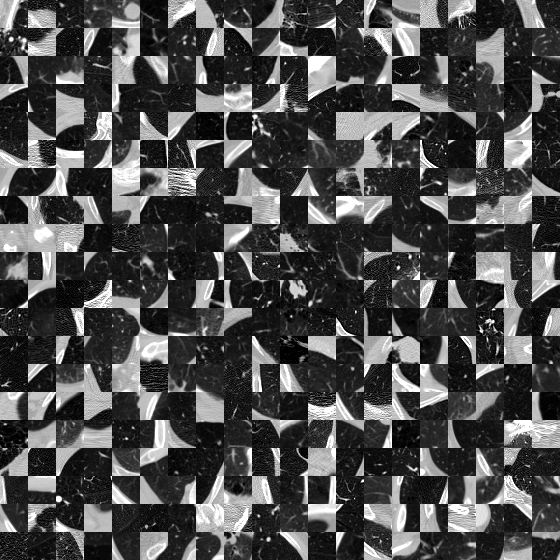

In [13]:
# hyparameters
BATCH_SIZE = 1024
EPOCH_NUM = 100
lr = 8e-4

# dataset
data_flag_3d = 'nodulemnist3d' # here the name of dataset should be passed.
download = True

info = INFO[data_flag_3d] # INFO is embedded in the medmnist containing basic information of datasets
print(info)
task = info['task']

n_channels = info['n_channels']
n_classes = len(info['label'])

# get the data class without transform
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split="train", download=download)
test_dataset = DataClass(split="test", download=download)
val_dataset = DataClass(split="val", download=download)

# encapsulate datasets into Dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# show the details
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)
train_dataset.montage(length=20)[0]

## 3D CNN implementation

Similar to what you have completed, please fill the blanks in following methods.

You expected to design a 3D CNN with 5 layers along with batch normalization and pooling.

In [14]:
class CNN_3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_3D, self).__init__()
        # 1 x 28 x 28 x 28
        self.conv_1 = nn.Sequential(
            nn.Conv3d(in_channels, 4, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm3d(4),
            nn.ReLU(),
            nn.MaxPool3d(2, 2)
        )
        # 4 x 14 x 14 x 14
        self.conv_2 = nn.Sequential(
            nn.Conv3d(4, 8, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.MaxPool3d(2,2)
        )
        # 8 x 7 x 7 x 7
        self.conv_3 = nn.Sequential(
            nn.Conv3d(8, 16, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2,2)
        )
        # 16 x 3 x 3 x 3
        self.conv_4 = nn.Sequential(
            nn.Conv3d(16, 16, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2,2)
        )
        # 16 x 1 x 1 x 1
        self.fc_1 = nn.Sequential(
            nn.Linear(16, 1),
        )
        # Output: 1 x num_classes

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = x.view(x.size(0), -1)
        x = self.fc_1(x)
        return x

# initialize the 3D model
cnn3d_model = CNN_3D(in_channels=n_channels, num_classes=n_classes)
cnn3d_model.to(device)
# define the BCE loss function and an optimizer you prefer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn3d_model.parameters(), lr=lr, weight_decay=0.01)

# show the details
from torchsummary import summary
SAMPLE_DATASIZE = (1, 28, 28, 28) # please pass the size of data size to SAMPLE_DATASIZE
summary(cnn3d_model, SAMPLE_DATASIZE, BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [1024, 4, 29, 29, 29]              36
       BatchNorm3d-2      [1024, 4, 29, 29, 29]               8
              ReLU-3      [1024, 4, 29, 29, 29]               0
         MaxPool3d-4      [1024, 4, 14, 14, 14]               0
            Conv3d-5      [1024, 8, 15, 15, 15]             264
       BatchNorm3d-6      [1024, 8, 15, 15, 15]              16
              ReLU-7      [1024, 8, 15, 15, 15]               0
         MaxPool3d-8         [1024, 8, 7, 7, 7]               0
            Conv3d-9        [1024, 16, 6, 6, 6]           1,040
      BatchNorm3d-10        [1024, 16, 6, 6, 6]              32
             ReLU-11        [1024, 16, 6, 6, 6]               0
        MaxPool3d-12        [1024, 16, 3, 3, 3]               0
           Conv3d-13        [1024, 16, 2, 2, 2]           2,064
      BatchNorm3d-14        [1024, 16, 

## Training and evaluation

Please fill empty blanks in the following block and modify the train and test functions if it is necessary. Note that train and test functions should work for both 2D CNN and 3D CNN.

100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Epoch training loss: 1.330


100%|██████████| 1/1 [00:00<00:00, 23.68it/s]


Epoch validation loss: 0.726


100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


Epoch training loss: 1.242


100%|██████████| 1/1 [00:00<00:00, 27.40it/s]


Epoch validation loss: 0.748


100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


Epoch training loss: 1.179


100%|██████████| 1/1 [00:00<00:00, 26.72it/s]


Epoch validation loss: 0.771


100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


Epoch training loss: 1.066


100%|██████████| 1/1 [00:00<00:00, 26.53it/s]


Epoch validation loss: 0.795


100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


Epoch training loss: 1.050


100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


Epoch validation loss: 0.818


100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


Epoch training loss: 1.038


100%|██████████| 1/1 [00:00<00:00, 27.94it/s]


Epoch validation loss: 0.841


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Epoch training loss: 1.011


100%|██████████| 1/1 [00:00<00:00, 31.66it/s]


Epoch validation loss: 0.859


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


Epoch training loss: 0.967


100%|██████████| 1/1 [00:00<00:00, 28.93it/s]


Epoch validation loss: 0.875


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Epoch training loss: 0.945


100%|██████████| 1/1 [00:00<00:00, 29.06it/s]


Epoch validation loss: 0.886


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Epoch training loss: 0.952


100%|██████████| 1/1 [00:00<00:00, 32.98it/s]


Epoch validation loss: 0.896


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


Epoch training loss: 0.917


100%|██████████| 1/1 [00:00<00:00, 30.34it/s]


Epoch validation loss: 0.901


100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


Epoch training loss: 0.902


100%|██████████| 1/1 [00:00<00:00, 25.82it/s]


Epoch validation loss: 0.904


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


Epoch training loss: 0.850


100%|██████████| 1/1 [00:00<00:00, 29.45it/s]


Epoch validation loss: 0.903


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Epoch training loss: 0.841


100%|██████████| 1/1 [00:00<00:00, 29.93it/s]


Epoch validation loss: 0.898


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Epoch training loss: 0.808


100%|██████████| 1/1 [00:00<00:00, 29.99it/s]


Epoch validation loss: 0.888


100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


Epoch training loss: 0.801


100%|██████████| 1/1 [00:00<00:00, 29.61it/s]


Epoch validation loss: 0.877


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


Epoch training loss: 0.787


100%|██████████| 1/1 [00:00<00:00, 29.12it/s]


Epoch validation loss: 0.865


100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


Epoch training loss: 0.773


100%|██████████| 1/1 [00:00<00:00, 28.29it/s]


Epoch validation loss: 0.850


100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Epoch training loss: 0.746


100%|██████████| 1/1 [00:00<00:00, 30.84it/s]


Epoch validation loss: 0.835


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Epoch training loss: 0.739


100%|██████████| 1/1 [00:00<00:00, 30.38it/s]


Epoch validation loss: 0.819


100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Epoch training loss: 0.729


100%|██████████| 1/1 [00:00<00:00, 29.94it/s]


Epoch validation loss: 0.802


100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Epoch training loss: 0.704


100%|██████████| 1/1 [00:00<00:00, 24.96it/s]


Epoch validation loss: 0.787


100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


Epoch training loss: 0.693


100%|██████████| 1/1 [00:00<00:00, 21.70it/s]


Epoch validation loss: 0.771


100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Epoch training loss: 0.681


100%|██████████| 1/1 [00:00<00:00, 24.15it/s]


Epoch validation loss: 0.756


100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


Epoch training loss: 0.667


100%|██████████| 1/1 [00:00<00:00, 23.78it/s]


Epoch validation loss: 0.742


100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Epoch training loss: 0.656


100%|██████████| 1/1 [00:00<00:00, 25.69it/s]


Epoch validation loss: 0.729


100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


Epoch training loss: 0.654


100%|██████████| 1/1 [00:00<00:00, 27.89it/s]


Epoch validation loss: 0.713


100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


Epoch training loss: 0.647


100%|██████████| 1/1 [00:00<00:00, 27.80it/s]


Epoch validation loss: 0.699


100%|██████████| 2/2 [00:00<00:00,  3.65it/s]


Epoch training loss: 0.647


100%|██████████| 1/1 [00:00<00:00, 30.49it/s]


Epoch validation loss: 0.686


100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


Epoch training loss: 0.629


100%|██████████| 1/1 [00:00<00:00, 29.58it/s]


Epoch validation loss: 0.673


100%|██████████| 2/2 [00:00<00:00,  3.65it/s]


Epoch training loss: 0.639


100%|██████████| 1/1 [00:00<00:00, 30.46it/s]


Epoch validation loss: 0.657


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Epoch training loss: 0.607


100%|██████████| 1/1 [00:00<00:00, 28.61it/s]


Epoch validation loss: 0.643


100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Epoch training loss: 0.598


100%|██████████| 1/1 [00:00<00:00, 31.81it/s]


Epoch validation loss: 0.631


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Epoch training loss: 0.588


100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


Epoch validation loss: 0.617


100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Epoch training loss: 0.579


100%|██████████| 1/1 [00:00<00:00, 31.54it/s]


Epoch validation loss: 0.605


100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Epoch training loss: 0.589


100%|██████████| 1/1 [00:00<00:00, 29.68it/s]


Epoch validation loss: 0.593


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


Epoch training loss: 0.573


100%|██████████| 1/1 [00:00<00:00, 30.51it/s]


Epoch validation loss: 0.582


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Epoch training loss: 0.579


100%|██████████| 1/1 [00:00<00:00, 25.80it/s]


Epoch validation loss: 0.573


100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch training loss: 0.578


100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


Epoch validation loss: 0.567


100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Epoch training loss: 0.546


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Epoch validation loss: 0.563


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch training loss: 0.556


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch validation loss: 0.559


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Epoch training loss: 0.543


100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


Epoch validation loss: 0.552


100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


Epoch training loss: 0.523


100%|██████████| 1/1 [00:00<00:00, 25.41it/s]


Epoch validation loss: 0.548


100%|██████████| 2/2 [00:00<00:00,  3.14it/s]


Epoch training loss: 0.537


100%|██████████| 1/1 [00:00<00:00, 30.81it/s]


Epoch validation loss: 0.548


100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


Epoch training loss: 0.516


100%|██████████| 1/1 [00:00<00:00, 30.19it/s]


Epoch validation loss: 0.546


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Epoch training loss: 0.525


100%|██████████| 1/1 [00:00<00:00, 28.10it/s]


Epoch validation loss: 0.544


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch training loss: 0.514


100%|██████████| 1/1 [00:00<00:00, 30.79it/s]


Epoch validation loss: 0.537


100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


Epoch training loss: 0.520


100%|██████████| 1/1 [00:00<00:00, 23.99it/s]


Epoch validation loss: 0.532


100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


Epoch training loss: 0.505


100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


Epoch validation loss: 0.527


100%|██████████| 2/2 [00:00<00:00,  3.65it/s]


Epoch training loss: 0.493


100%|██████████| 1/1 [00:00<00:00, 28.11it/s]


Epoch validation loss: 0.523


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Epoch training loss: 0.498


100%|██████████| 1/1 [00:00<00:00, 30.21it/s]


Epoch validation loss: 0.520


100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


Epoch training loss: 0.494


100%|██████████| 1/1 [00:00<00:00, 29.70it/s]


Epoch validation loss: 0.515


100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


Epoch training loss: 0.482


100%|██████████| 1/1 [00:00<00:00, 27.92it/s]


Epoch validation loss: 0.510


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Epoch training loss: 0.490


100%|██████████| 1/1 [00:00<00:00, 26.78it/s]


Epoch validation loss: 0.503


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Epoch training loss: 0.470


100%|██████████| 1/1 [00:00<00:00, 30.97it/s]


Epoch validation loss: 0.499


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Epoch training loss: 0.492


100%|██████████| 1/1 [00:00<00:00, 28.90it/s]


Epoch validation loss: 0.497


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Epoch training loss: 0.467


100%|██████████| 1/1 [00:00<00:00, 29.28it/s]


Epoch validation loss: 0.493


100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


Epoch training loss: 0.478


100%|██████████| 1/1 [00:00<00:00, 28.62it/s]


Epoch validation loss: 0.486


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Epoch training loss: 0.444


100%|██████████| 1/1 [00:00<00:00, 33.16it/s]


Epoch validation loss: 0.479


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Epoch training loss: 0.453


100%|██████████| 1/1 [00:00<00:00, 28.12it/s]


Epoch validation loss: 0.473


100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


Epoch training loss: 0.470


100%|██████████| 1/1 [00:00<00:00, 25.40it/s]


Epoch validation loss: 0.469


100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


Epoch training loss: 0.448


100%|██████████| 1/1 [00:00<00:00, 25.88it/s]


Epoch validation loss: 0.471


100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


Epoch training loss: 0.442


100%|██████████| 1/1 [00:00<00:00, 25.33it/s]


Epoch validation loss: 0.471


100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch training loss: 0.441


100%|██████████| 1/1 [00:00<00:00, 28.81it/s]


Epoch validation loss: 0.467


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


Epoch training loss: 0.447


100%|██████████| 1/1 [00:00<00:00, 31.26it/s]


Epoch validation loss: 0.460


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


Epoch training loss: 0.447


100%|██████████| 1/1 [00:00<00:00, 25.69it/s]


Epoch validation loss: 0.457


100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


Epoch training loss: 0.442


100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


Epoch validation loss: 0.456


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Epoch training loss: 0.431


100%|██████████| 1/1 [00:00<00:00, 25.85it/s]


Epoch validation loss: 0.454


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Epoch training loss: 0.419


100%|██████████| 1/1 [00:00<00:00, 29.52it/s]


Epoch validation loss: 0.453


100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


Epoch training loss: 0.410


100%|██████████| 1/1 [00:00<00:00, 29.11it/s]


Epoch validation loss: 0.452


100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


Epoch training loss: 0.417


100%|██████████| 1/1 [00:00<00:00, 28.91it/s]


Epoch validation loss: 0.452


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Epoch training loss: 0.413


100%|██████████| 1/1 [00:00<00:00, 27.46it/s]


Epoch validation loss: 0.451


100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


Epoch training loss: 0.404


100%|██████████| 1/1 [00:00<00:00, 29.29it/s]


Epoch validation loss: 0.448


100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


Epoch training loss: 0.413


100%|██████████| 1/1 [00:00<00:00, 27.28it/s]


Epoch validation loss: 0.442


100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


Epoch training loss: 0.408


100%|██████████| 1/1 [00:00<00:00, 29.65it/s]


Epoch validation loss: 0.439


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Epoch training loss: 0.410


100%|██████████| 1/1 [00:00<00:00, 25.59it/s]


Epoch validation loss: 0.437


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Epoch training loss: 0.411


100%|██████████| 1/1 [00:00<00:00, 26.69it/s]


Epoch validation loss: 0.436


100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


Epoch training loss: 0.403


100%|██████████| 1/1 [00:00<00:00, 29.67it/s]


Epoch validation loss: 0.435


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch training loss: 0.389


100%|██████████| 1/1 [00:00<00:00, 26.86it/s]


Epoch validation loss: 0.431


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch training loss: 0.403


100%|██████████| 1/1 [00:00<00:00, 22.70it/s]


Epoch validation loss: 0.427


100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


Epoch training loss: 0.398


100%|██████████| 1/1 [00:00<00:00, 26.78it/s]


Epoch validation loss: 0.423


100%|██████████| 2/2 [00:00<00:00,  3.14it/s]


Epoch training loss: 0.385


100%|██████████| 1/1 [00:00<00:00, 24.99it/s]


Epoch validation loss: 0.419


100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


Epoch training loss: 0.394


100%|██████████| 1/1 [00:00<00:00, 26.04it/s]


Epoch validation loss: 0.418


100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


Epoch training loss: 0.368


100%|██████████| 1/1 [00:00<00:00, 28.99it/s]


Epoch validation loss: 0.422


100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


Epoch training loss: 0.375


100%|██████████| 1/1 [00:00<00:00, 29.93it/s]


Epoch validation loss: 0.425


100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


Epoch training loss: 0.377


100%|██████████| 1/1 [00:00<00:00, 26.48it/s]


Epoch validation loss: 0.423


100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


Epoch training loss: 0.379


100%|██████████| 1/1 [00:00<00:00, 24.75it/s]


Epoch validation loss: 0.419


100%|██████████| 2/2 [00:00<00:00,  3.55it/s]


Epoch training loss: 0.380


100%|██████████| 1/1 [00:00<00:00, 25.10it/s]


Epoch validation loss: 0.415


100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Epoch training loss: 0.362


100%|██████████| 1/1 [00:00<00:00, 27.92it/s]


Epoch validation loss: 0.412


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Epoch training loss: 0.360


100%|██████████| 1/1 [00:00<00:00, 29.73it/s]


Epoch validation loss: 0.415


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch training loss: 0.358


100%|██████████| 1/1 [00:00<00:00, 29.44it/s]


Epoch validation loss: 0.420


100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Epoch training loss: 0.350


100%|██████████| 1/1 [00:00<00:00, 26.43it/s]


Epoch validation loss: 0.415


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Epoch training loss: 0.366


100%|██████████| 1/1 [00:00<00:00, 25.73it/s]


Epoch validation loss: 0.408


100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Epoch training loss: 0.337


100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


Epoch validation loss: 0.407


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Epoch training loss: 0.364


100%|██████████| 1/1 [00:00<00:00, 29.52it/s]


Epoch validation loss: 0.407


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch training loss: 0.343


100%|██████████| 1/1 [00:00<00:00, 28.91it/s]


Epoch validation loss: 0.411


100%|██████████| 2/2 [00:00<00:00,  3.55it/s]


Epoch training loss: 0.336


100%|██████████| 1/1 [00:00<00:00, 30.12it/s]


Epoch validation loss: 0.414


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Epoch training loss: 0.339


100%|██████████| 1/1 [00:00<00:00, 27.44it/s]


Epoch validation loss: 0.409


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch training loss: 0.347


100%|██████████| 1/1 [00:00<00:00, 28.23it/s]


Epoch validation loss: 0.397


100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


Epoch training loss: 0.338


100%|██████████| 1/1 [00:00<00:00, 21.14it/s]


Epoch validation loss: 0.396


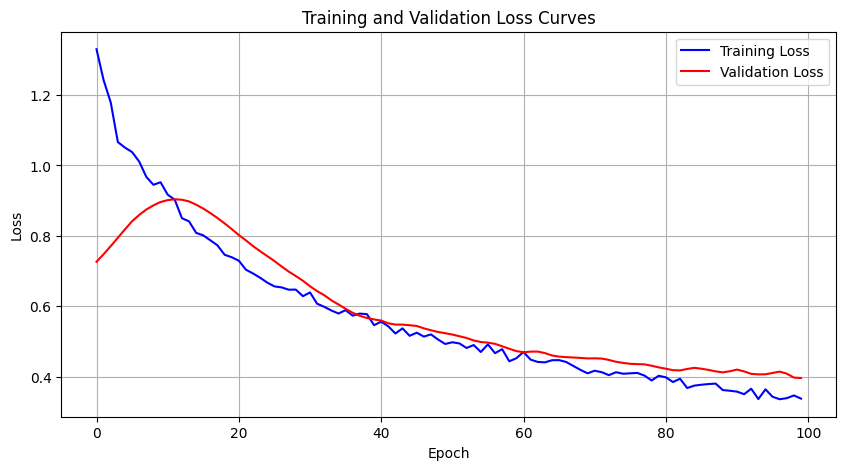

100%|██████████| 1/1 [00:00<00:00, 11.11it/s]

auc: 0.863, acc: 0.816


In [15]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
# train
loss_values, val_loss_values, model = train(train_loader=train_loader, model=cnn3d_model)

# show training and validation curves
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# test
auc, acc = test(test_loader=test_loader, model=cnn3d_model)
print(f'auc: {auc:.3f}, acc: {acc:.3f}') # round both to the first 3 digits

# What are the strengths and weaknesses of classification models?
### In the previous tasks, you worked on CNN and 3D CNN. What are other networks that can realize image classification? (Please make at least 3 examples.) Could you discuss the pros and cons of CNNs and the networks you listed in medical image classification?

Other networks that can realize image classification include: Resnet/ Densenet, RNNs and Transformers.<br>
CNN pros:<br>
CNNs are the simplest of those architectures, providing a robust, good performance on well known tasks like imagenet. Thanks to the convolutional layers, few neurons can have a large receptive field and thus learn features over a lot of information/ large parts of the image. They were orignially designed for image classification and are well adapted to this task.<br>
CNN cons:<br>
CNNs in older versions often had a lot of parameters, causing them to be slow during training. Additionally it can be hard for developers to understand what layer learned what feature, as they mostly work like a black box. They also need a lot of data. But the main disadvantage of CNNs compared to the other methods above is the performance degradation when more layers are added and that they have no memory and can not hadle continuous inputs.<br>
Resnet pros:<br>
ResNet and DenseNet both build on CNNs by allowing for skip connections, that directly feed the output of previous layers to future layers. This allows for deeper architectures without performance degradation. Additionally they provide higher parameter efficiency than CNNs as no "copy neurons" are necessary and the feature propagation is improved.<br>
Resnet cons:<br>
But they still can not handle continuous inputs and do not have memory (which would be relevant for videos that are common in Ultrasound Imaging or functional imaging in MRIs of the heart and PET scans). They are also more complex than CNNs.<br>
RNN pros:<br>
RNNs add looping connections, creating memory over time sequences and allow them to handle continuous data. This also results in more efficient training when the data contains sequential relationships (e.g. data that "goes back in time" where later inputs influence earlier ones).<br>
RNN cons:<br>
Yet again RNNs are inherently more complex than the above models, as they build on them. Compared to the following architecture type, they also have disadvantages, namely that they must be computed sequentially instead of in parallel. This means, that the network must "decide" which features are most relevant before knowing the full context for early inputs and that they are slow on long input sequences. Another main problem is the vanishing/ exploding gradients problem rendering the network less stable (although this can be reduced/ mitigated with different variants such as LSTM, weight initialization and more).<br>
Transformers pros:<br>
The main advantage over RNNs is that they can compute continuous inputs in parallel, drastically improving efficiency on long input sequences. They can additionally handle longer input sequences which can prove useful for data gathered over a long time, like long ultrasound scans.<br>
Transformers cons:<br>
They are the most complex of the mentioned models. While many of the above architectures were orignally developed for image classification tasks, transformers can be generalized to handle this task, but the vanilla version was originally optimizd for text based models and natural language processing.